In [6]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Dynamic processing

This notebooks analyzes the dynamic tests performed on the ADC.

First, read in the data.

In [144]:
data = pd.read_csv("sine_0.csv")

# Subtract start time.
start = data.t.values[0]
data.t -= start
# To ms.
data.t /= 1000000
# data.t.values[0]
data.head()
data.describe()
# data = data.drop(data[data["code"] < 0].index)

,t,vout,code,vout_meas,vref
0,0.0000,2.300000,512.0,2.300000,4.6
1,0.1958,3.651906,999.0,3.651906,4.6
2,0.3974,4.487430,1001.0,4.487430,4.6
3,0.5915,4.487430,814.0,4.487430,4.6
4,0.7553,3.651906,512.0,3.651906,4.6


,t,vout,code,vout_meas,vref
count,28000.000000,28000.000000,28000.000000,28000.000000,2.800000e+04
mean,4999.129810,2.300000,512.341393,2.300000,4.600000e+00
std,2886.503004,1.626375,362.808276,1.626375,2.336839e-12
min,0.000000,0.112570,-1.000000,0.112570,4.600000e+00
25%,2498.966550,0.948094,210.000000,0.948094,4.600000e+00
50%,4998.821900,2.300000,512.000000,2.300000,4.600000e+00
75%,7498.715750,3.651906,815.000000,3.651906,4.600000e+00
max,11014.021100,4.487430,1004.000000,4.487430,4.600000e+00


In [145]:
def normalize(input_data):
    maximum = np.max(input_data)
    return np.float64(input_data / maximum)
    # return input_data / len(input_data)

def normalized_fourier(signal, sample_rate, signal_length):
    # transformed_signal = np.abs(np.fft.rfft(signal)) / np.max(signal)
    transformed_signal = np.abs(np.fft.rfft(signal)) / signal_length
    resolution = sample_rate / signal_length

    x = [x * resolution for x in range(len(transformed_signal))]

    return transformed_signal, x

def to_decibels(signal, power=False):
    ref = np.max(signal)
    if power:
        output = 10 * np.log10(signal / ref)
    else:
        output = 20 * np.log10(signal / ref)
    return output

In [146]:
def sine(n_samples: int, periods: float, min_value: float, max_value: float):
        x = np.linspace(0, 2 * np.pi * periods, n_samples, endpoint=False)
        # Create a sine wave and also map it to the specified range.
        return np.interp(np.sin(x), [-1, 1], [min_value, max_value])

def code_to_v(code, vref, res=1024):
        return code * vref / res

In [147]:
def fft_real(signal, power=False):
    fft = np.abs(np.fft.rfft(signal)) / len(signal)
    fft[1:] *= 2

    if power:
        fft **= 2
    
    return fft

Calculate all the indices and powers.

In [208]:
n_samples = len(data)
fs = 2800
frequency = 280
periods = n_samples / fs * frequency
output_data = sine(n_samples, periods, 0, 4.6)

fft_ideal = fft_real(output_data, power=True)
fft_actual = fft_real(code_to_v(data.code, data.vref), power=True)

# Signal power
idx_fundamental = int(frequency * n_samples / fs)
idx_fundamental
fundamental_power = fft_actual[idx_fundamental]
signal_power = fundamental_power

# Harmonics' power
f_harmonics = np.array([frequency * i for i in range(2, 6)])
f_harmonics
idx_harmonics = f_harmonics * n_samples / fs
idx_harmonics = idx_harmonics.astype(np.int64)
harmonics_powers = fft_actual[idx_harmonics]
harmonics_power = np.sum(harmonics_powers)

# Noise power
idx_noise = list(range(1, len(fft_actual)))  # Start from 1 to exclude the DC component.
idx_noise.remove(idx_fundamental)
for harmonics_i in idx_harmonics:
    idx_noise.remove(harmonics_i)
noise_powers = fft_actual[idx_noise]
noise_power = np.sum(noise_powers)

2800

array([ 560,  840, 1120, 1400])

The original plan was just to subtract the ideal power from the measured power, but since the harmonics also needed to be subtracted, the only reasonable way to do this right now is just to remove all the corresponding indices.

### Total harmonic distortion

Usually, when calculating the THD, only 5–6 first harmonics are considered.

In [164]:
thd = fundamental_power / harmonics_power
thd = 10 * np.log10(thd)
thd

63.89682488123462

### Signal-to-noise ratio

To calculate the SNR, we need to know both the power spectrum of the signal and the noise. For this, let's first calculate the ideal signal's power spectrum and then subtract it from the real signal's spectrum to find the noise. Note, that usually frequency 0 (DC offset) and the first 5–6 harmonics are not taken into account.

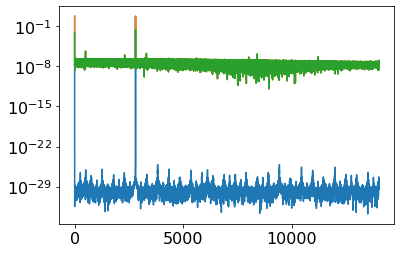

In [157]:
# fft_ideal[2798:2803]
# fft_actual[2798:2803]

# plt.plot(fft_actual)
# plt.plot(fft_ideal)
# plt.plot(fft_actual - fft_ideal)
# plt.plot(to_decibels(fft_actual, power=True))
# plt.plot(to_decibels(fft_ideal, power=True))
# plt.plot(to_decibels(fft_actual - fft_ideal, power=True))
plt.semilogy(fft_ideal)
plt.semilogy(fft_actual)
plt.semilogy(fft_actual - fft_ideal)

In [165]:
# Old version:
# signal_power = np.sum(fft_ideal[1:])
# noise_power = np.sum(fft_actual[1:] - fft_ideal[1:])
# snr = 10 * np.log10(signal_power / noise_power)
# snr

# New version:
snr = 10 * np.log10(signal_power / noise_power)
snr

37.75292810018851

Also find the ideal SNR (equal to SINAD when assuming that there is no distortion).

In [174]:
snr_ideal = 6.02 * 10 + 1.76
snr_ideal

61.959999999999994

### Spurious-free dynamic range

To calculate the SFDR, we need to find the non-signal component with the highest power, be it either a harmonic of the signal or some other frequency component. DC power is not taken into account.

In [177]:
powers_idx = list(np.flip(np.argsort(fft_actual)))
powers_idx.remove(0)  # Remove the DC component.
powers_idx.remove(idx_fundamental)  # Remove the signal.
spurious_idx = powers_idx[0]
sfdr = fundamental_power / fft_actual[spurious_idx]
sfdr = 10 * np.log10(sfdr)
sfdr

60.73925874798427

### SINAD

This is just the combination of SNR and THD, also called THD+N.

In [163]:
sinad = signal_power / (noise_power + harmonics_power)
sinad = 10 * np.log10(sinad)
sinad

37.7423874477357

### ENOB

The effective number of bits describes the dynamic range of the system and can be lower than the specified resolution in number of bits. Another way of thinking about ENOB is that this number of bits behave equivalently to a perfect ADC.

In [166]:
enob = (sinad - 1.76) / 6.02
enob

5.977140772049121

### Noise floor

Also add the noise floor as the average power of the noise.

In [212]:
noise_floor = np.mean(noise_powers)
noise_floor = 10 * np.log10(signal_power / noise_floor)
noise_floor

79.21265712821032

### Combined results

Finally, let's create a plot which shows many of the previously calculated errors together in dBFS.

<Figure size 1080x720 with 0 Axes>

Text(0.5, 0, 'Frequency (Hz)')

Text(0, 0.5, 'Power (dBFS)')

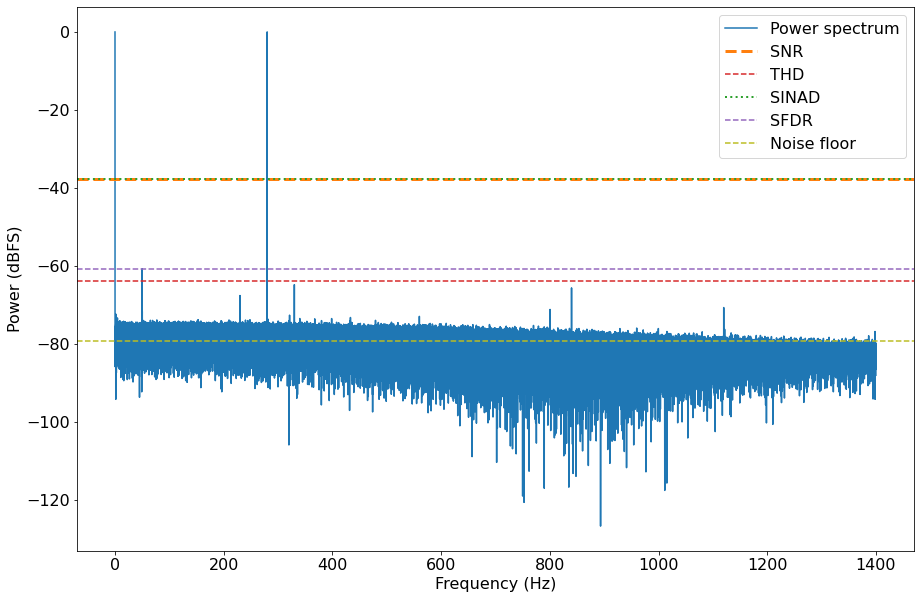

In [218]:
resolution = fs / n_samples
x = [x * resolution for x in range(len(fft_actual))]

plt.figure(figsize=(15, 10))

fft_ideal_dbfs = to_decibels(fft_ideal, power=True)
fft_actual_dbfs = to_decibels(fft_actual, power=True)
plt.plot(x, fft_actual_dbfs, label="Power spectrum")

plt.axhline(-snr, label="SNR", color="tab:orange", linestyle="--", linewidth=3)
plt.axhline(-thd, label="THD", color="tab:red", linestyle="--")
plt.axhline(-sinad, label="SINAD", color="tab:green", linestyle=":", alpha=1, linewidth=2)
plt.axhline(-sfdr, label="SFDR", color="tab:purple", linestyle="--")
plt.axhline(-noise_floor, label="Noise floor", color="tab:olive", linestyle="--")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBFS)')
plt.legend()
plt.savefig("dynamic.png")

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Frequency (Hz)')

Text(0, 0.5, 'Linear spectrum (V RMS)')

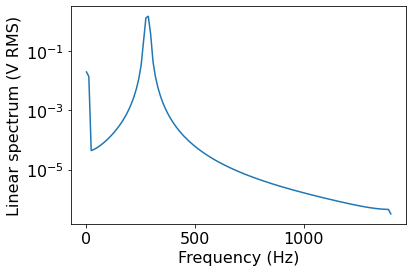

In [175]:
f, Pxx_spec = signal.welch(output_data, fs, scaling="spectrum")
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Linear spectrum (V RMS)')
plt.show()

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Frequency (Hz)')

Text(0, 0.5, 'Linear spectrum (V RMS)')

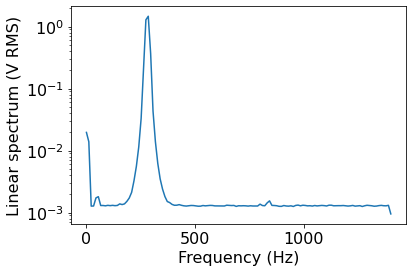

In [176]:
# f, Pxx_spec = signal.welch(data.code, fs, scaling='spectrum')
f, Pxx_spec = signal.welch(code_to_v(data.code, 4.6), fs, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Linear spectrum (V RMS)')
plt.show()

The following was an initial attempt at SNR calculation, not relevant anymore.

In [75]:
fft = np.abs(np.fft.rfft(data.code))

print(fft.argsort()[-2:])

signal_power = np.sum(fft[fft.argsort()[-2:]] ** 2)
print(signal_power)
noise_indices = list(range(len(fft)))
del noise_indices[0]
del noise_indices[2799]
print(len(noise_indices))
noise_power = np.sum(fft[noise_indices] ** 2)
print(noise_power)

snr = 10 * np.log10(signal_power / noise_power)
print(snr)

[2800    0]
257383443772970.7
13999
8675872314.322504
44.72267455677929


<Figure size 1080x720 with 0 Axes>

Text(0.5, 0, 'Frequency (Hz)')

Text(0, 0.5, 'dB')

Text(0, 0, 'SNR = ~76 dB')

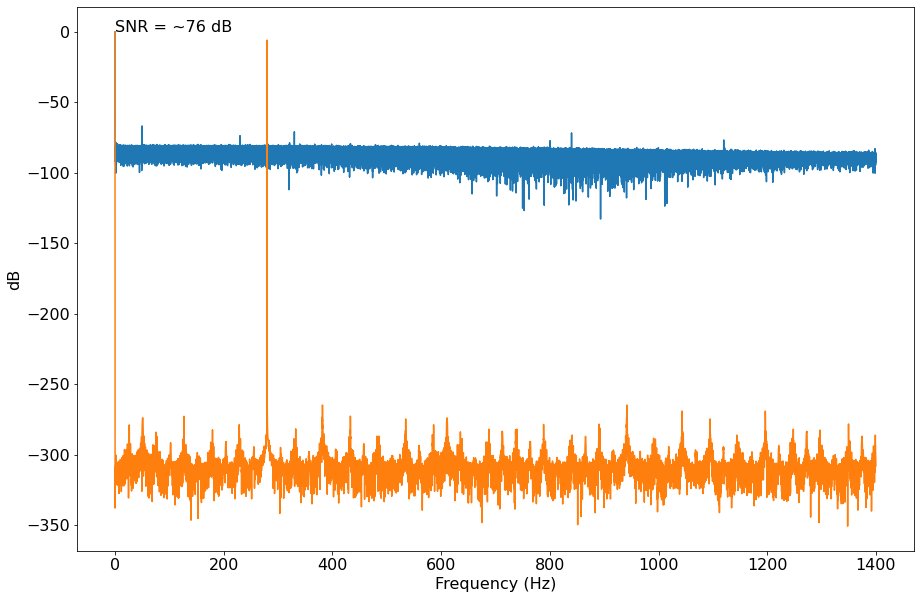

In [47]:
fft, x = normalized_fourier(data.code, 2800, 28000)
fft = to_decibels(fft)

fft_, x = normalized_fourier(output_data, 2800, 28000)
fft_ = to_decibels(fft_)

plt.rc("font", size=16)
plt.figure(figsize=(15, 10))
plt.plot(x, fft)
plt.plot(x, fft_)
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.text(0, 0, s="SNR = ~76 dB")

### Input-referred noise

In [243]:
input_noise_data = pd.read_csv("input_noise_0.csv")

# Subtract start time.
start = input_noise_data.t.values[0]
input_noise_data.t -= start
# To ms.
input_noise_data.t /= 1000000
# data.t.values[0]
input_noise_data = input_noise_data[input_noise_data["code"] >= 0]
input_noise_data.head()

,t,vout,code,vout_meas,vref
0,0.0000,2.5,558.0,2.5,4.6
1,0.3417,2.5,558.0,2.5,4.6
2,0.5607,2.5,557.0,2.5,4.6
3,0.7863,2.5,557.0,2.5,4.6
4,1.0016,2.5,558.0,2.5,4.6


In [244]:
plt.figure(figsize=(15, 5))
center_code = input_noise_data.code.mode().values[0]
input_noise_data.code -= center_code

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

(array([1.84018402e-02, 6.38763876e-01, 3.31933193e-01, 1.06010601e-02,
       3.00030003e-04]), array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5]), <BarContainer object of 5 artists>)


Text(0.5, 0, 'ADC code')

Text(0, 0.5, 'Probability mass / density')

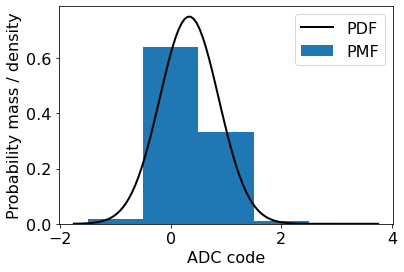

In [249]:
from scipy.stats import norm
mean, std_dev = norm.fit(input_noise_data.code.astype(int))

values = input_noise_data.code.astype(int)

bins = list(np.sort(values.unique()) - 0.5)
bins.append(np.max(bins) + 1)
real_hist = plt.hist(input_noise_data.code.astype(int), bins=bins, density=True, label="PMF")
print(real_hist)
# real_hist = plt.hist(input_noise_data.code.astype(int))

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label="PDF")


plt.xlabel("ADC code")
plt.ylabel("Probability mass / density")
plt.legend()

In [246]:
input_noise_data.code.value_counts()
# input_noise_data.code.argmin()

 0.0    6387
 1.0    3319
-1.0     184
 2.0     106
 3.0       3
Name: code, dtype: int64